# Import libraries

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [18]:
df=pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908.csv')
df.head(5)

Date   Time                            Location  \
0  09/17/1908  17:18                 Fort Myer, Virginia   
1  07/12/1912  06:30             AtlantiCity, New Jersey   
2  08/06/1913    NaN  Victoria, British Columbia, Canada   
3  09/09/1913  18:30                  Over the North Sea   
4  10/17/1913  10:30          Near Johannisthal, Germany   

                 Operator Flight #          Route                    Type  \
0    Military - U.S. Army      NaN  Demonstration        Wright Flyer III   
1    Military - U.S. Navy      NaN    Test flight               Dirigible   
2                 Private        -            NaN        Curtiss seaplane   
3  Military - German Navy      NaN            NaN  Zeppelin L-1 (airship)   
4  Military - German Navy      NaN            NaN  Zeppelin L-2 (airship)   

  Registration cn/In  Aboard  Fatalities  Ground  \
0          NaN     1     2.0         1.0     0.0   
1          NaN   NaN     5.0         5.0     0.0   
2          NaN   NaN     1.0         1.0     0.0   
3          NaN   NaN    20.0        14.0     0.0   
4          NaN   NaN    30.0        30.0     0.0   

                                             Summary  
0  During a demonstration flight, a U.S. Army fly...  
1  First U.S. dirigible Akron exploded just offsh...  
2  The first fatal airplane accident in Canada oc...  
3  The airship flew into a thunderstorm and encou...  
4  Hydrogen gas which was being vented was sucked...

In [19]:
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Year'].head(5)

0    1908
1    1912
2    1913
3    1913
4    1913
Name: Year, dtype: int64

# Data Cleaning

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          5268 non-null   object 
 1   Time          3049 non-null   object 
 2   Location      5248 non-null   object 
 3   Operator      5250 non-null   object 
 4   Flight #      1069 non-null   object 
 5   Route         3562 non-null   object 
 6   Type          5241 non-null   object 
 7   Registration  4933 non-null   object 
 8   cn/In         4040 non-null   object 
 9   Aboard        5246 non-null   float64
 10  Fatalities    5256 non-null   float64
 11  Ground        5246 non-null   float64
 12  Summary       4878 non-null   object 
 13  Year          5268 non-null   int64  
dtypes: float64(3), int64(1), object(10)
memory usage: 576.3+ KB


In [21]:
df.columns

Index(['Date', 'Time', 'Location', 'Operator', 'Flight #', 'Route', 'Type',
       'Registration', 'cn/In', 'Aboard', 'Fatalities', 'Ground', 'Summary',
       'Year'],
      dtype='object')

In [22]:
df.isna().sum()

Date               0
Time            2219
Location          20
Operator          18
Flight #        4199
Route           1706
Type              27
Registration     335
cn/In           1228
Aboard            22
Fatalities        12
Ground            22
Summary          390
Year               0
dtype: int64

In [23]:
data = df.dropna()
data.head(3)

Date   Time               Location  \
208  01/19/1930  18:23  Oceanside, California   
236  03/31/1931  10:45         Bazaar, Kansas   
334  08/31/1934  23:42     Amazonia, Missouri   

                              Operator Flight #  \
208                    Maddux Airlines        7   
236  Trans Continental and Western Air      599   
334                Rapid Air Transport        6   

                                    Route                   Type Registration  \
208   Aqua Caliente, Mexico - Los Angeles  Ford 5-AT-C Tri Motor       NC9689   
236  Kansas City - Wichita -  Los Angeles   Fokker F10A Trimotor       NC-999   
334                    Omaha - St. Joseph      Stinson  SM-6000B      NC10809   

        cn/In  Aboard  Fatalities  Ground  \
208  5-AT-046    16.0        16.0     0.0   
236      1063     8.0         8.0     0.0   
334      5004     5.0         5.0     0.0   

                                               Summary  Year  
208  While en route to Los Angeles, the pilot, flyi...  1930  
236  Shortly after taking off from Kansas City, one...  1931  
334  The plane crashed about 11 miles from St. Jose...  1934

In [24]:
print('number of rows  before discarding duplicates = %d' % (data.shape[0]))
airplane= data.drop_duplicates()
print("number of rows after discarding duplicates = %d" % (data.shape[0]))

number of rows  before discarding duplicates = 944
number of rows after discarding duplicates = 944


In [25]:
airplane.isnull().values.any()

False

# EDA

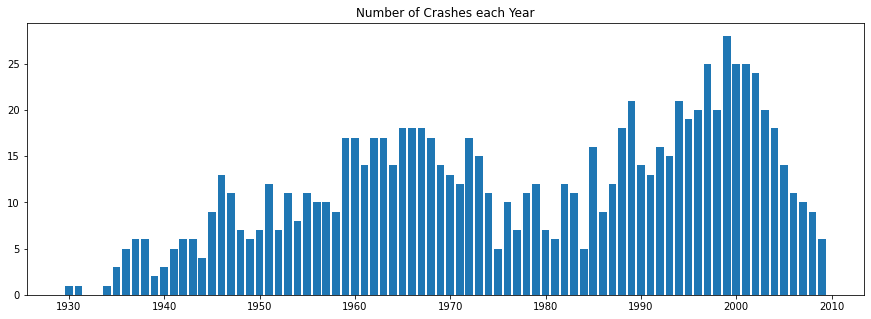

In [26]:
Crshs=pd.DataFrame(airplane.Year.value_counts())

plt.figure(figsize=(15, 5))
plt.bar(x=Crshs.index, height=Crshs["Year"])
plt.title("Number of Crashes each Year")
plt.show()

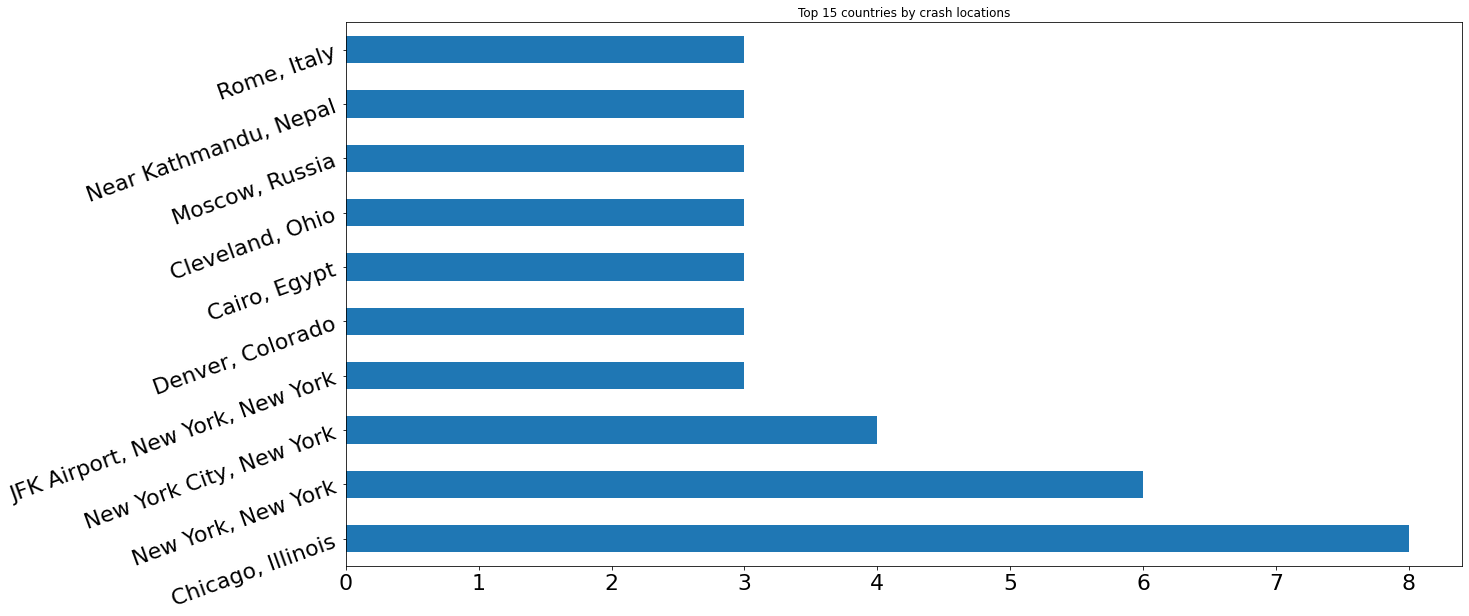

In [27]:
airplane['Location'].value_counts()[:10].plot(kind='barh'
                                        ,  figsize=(20,10), rot=20, fontsize=22, title="Top 15 countries by crash locations")

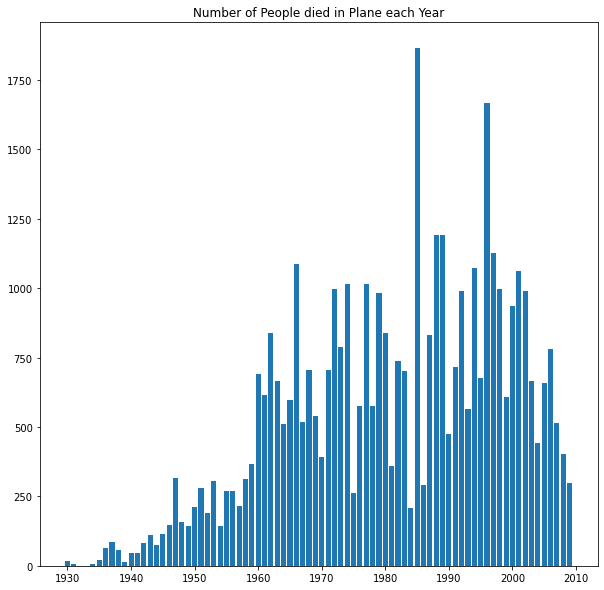

In [28]:
fatals=pd.DataFrame(airplane.Fatalities.groupby(airplane.Year).sum())

plt.figure(figsize=(10, 10))
plt.bar(x=fatals.index, height=fatals["Fatalities"])
plt.title("Number of People died in Plane each Year")
plt.show()

In [29]:
airplane['Survivor']=airplane['Aboard']-airplane['Fatalities']
airplane.head(2)

Date   Time               Location  \
208  01/19/1930  18:23  Oceanside, California   
236  03/31/1931  10:45         Bazaar, Kansas   

                              Operator Flight #  \
208                    Maddux Airlines        7   
236  Trans Continental and Western Air      599   

                                    Route                   Type Registration  \
208   Aqua Caliente, Mexico - Los Angeles  Ford 5-AT-C Tri Motor       NC9689   
236  Kansas City - Wichita -  Los Angeles   Fokker F10A Trimotor       NC-999   

        cn/In  Aboard  Fatalities  Ground  \
208  5-AT-046    16.0        16.0     0.0   
236      1063     8.0         8.0     0.0   

                                               Summary  Year  Survivor  
208  While en route to Los Angeles, the pilot, flyi...  1930       0.0  
236  Shortly after taking off from Kansas City, one...  1931       0.0

In [30]:
FSG_per_year = airplane[['Year', 'Fatalities', 'Survivor', 'Ground']].groupby('Year').sum()
FSG_per_year = FSG_per_year.reset_index()

Text(0, 0.5, 'Count')

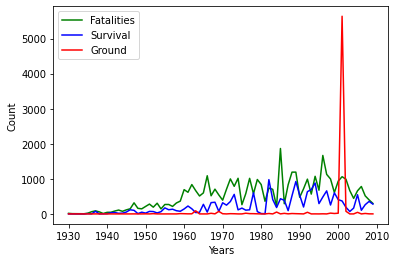

In [31]:
sns.lineplot(x = 'Year', y = 'Fatalities', data = FSG_per_year, color = 'green')
sns.lineplot(x = 'Year', y = 'Survivor', data = FSG_per_year, color = 'blue')
sns.lineplot(x = 'Year', y = 'Ground', data = FSG_per_year, color = 'red')
plt.legend(['Fatalities', 'Survival', 'Ground'])
plt.xlabel('Years')
plt.ylabel('Count')

In [32]:
Locations = airplane.groupby('Location', as_index=False).agg({'Year':'mean'}).sort_values('Year', ascending=False)

In [33]:
fig = px.choropleth(Locations, 
                    locations = 'Location', 
                    locationmode = 'country names', 
                    color = 'Year',
                    hover_data = ['Year'], 
                    title = 'Most Dangerous Locations per years')
fig.show()

In [34]:
SurvivorByPlaneType=pd.DataFrame(airplane.Survivor.groupby(airplane.Type).sum())
SurvivorByPlaneType = SurvivorByPlaneType.sort_values(by='Survivor', ascending=False)
SurvivorByPlaneType.head(5)

Survivor
Type                                  
McDonnell Douglas DC-10-30       871.0
McDonnell Douglas DC-10-30CF     838.0
Boeing B-747-122                 739.0
Boeing B-747-121                 586.0
McDonnell Douglas DC-10-10       527.0

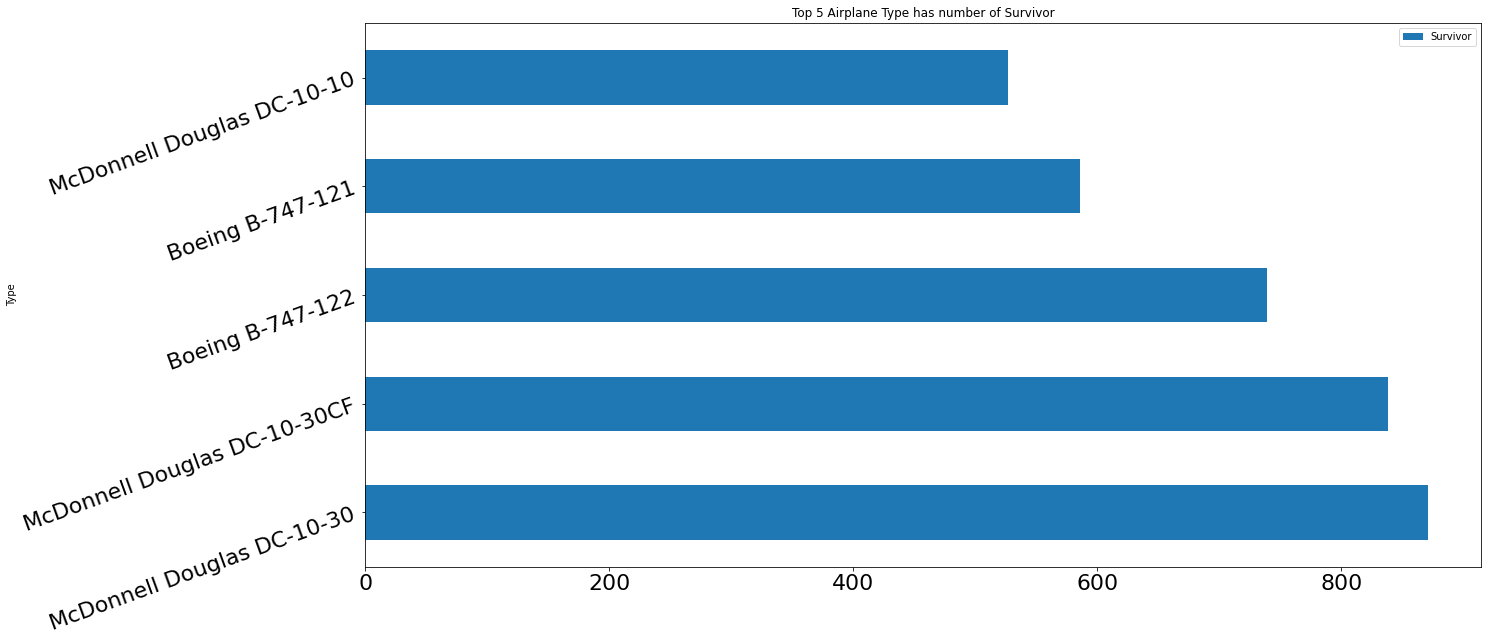

In [35]:
SurvivorByPlaneType[:5].plot(kind='barh'
                                        ,  figsize=(20,10), rot=20, fontsize=22, title="Top 5 Airplane Type has number of Survivor")

In [36]:
CrashesByPlaneType=pd.DataFrame(airplane.Fatalities.groupby(airplane.Type).sum())
CrashesByPlaneType = CrashesByPlaneType.sort_values(by='Fatalities', ascending=False)
CrashesByPlaneType.head(5)

Fatalities
Type                                            
Douglas DC-3                               929.0
McDonnell Douglas DC-10-10                 804.0
McDonnell Douglas DC-9-32                  650.0
Tupolev TU-154M                            640.0
Boeing B-747-121 / Boeing B-747-206B       583.0

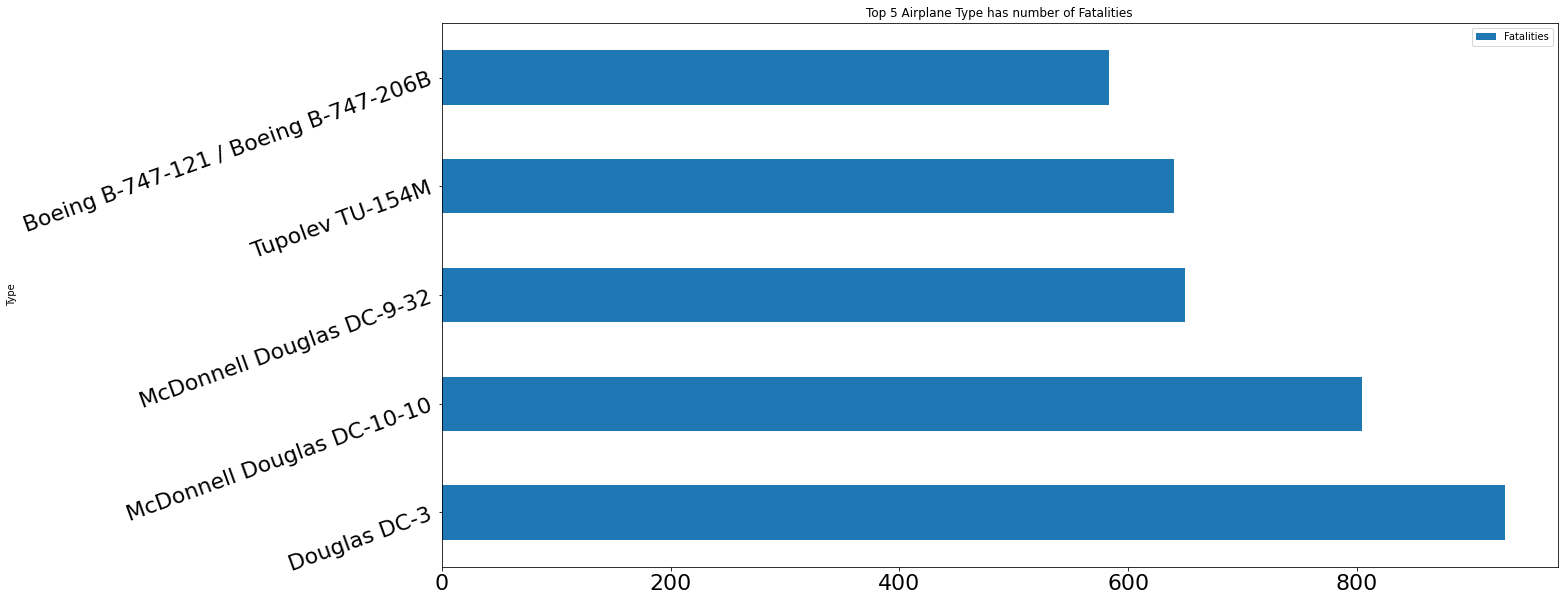

In [37]:
CrashesByPlaneType[:5].plot(kind='barh'
                                        ,  figsize=(20,10), rot=20, fontsize=22, title="Top 5 Airplane Type has number of Fatalities")

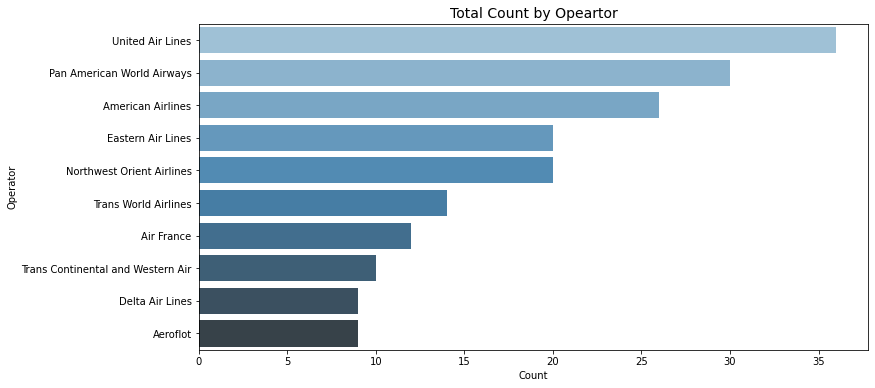

In [38]:
Opreator_total = airplane.groupby('Operator')[['Operator']].count()
Opreator_total = Opreator_total.rename(columns={"Operator": "Count"}) 
Opreator_total = Opreator_total.sort_values(by='Count', ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(y=Opreator_total.index, x="Count", data=Opreator_total,palette="Blues_d",orient='h')
plt.xlabel('Count', fontsize=10)
plt.ylabel('Operator', fontsize=10)
plt.title('Total Count by Opeartor', loc='Center', fontsize=14)
plt.show()

# Data Pre-processing

In [ ]:
import re
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text
airplane['Summary_clean'] = airplane['Summary'].apply(clean_text)
airplane.head()

# StopWords

from nltk.corpus import stopwords
data_text = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
data_text = data_text + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in data_text)
    return text
    
airplane['Summary_clean'] = airplane['Summary_clean'].apply(remove_stopwords)
airplane.head(2)

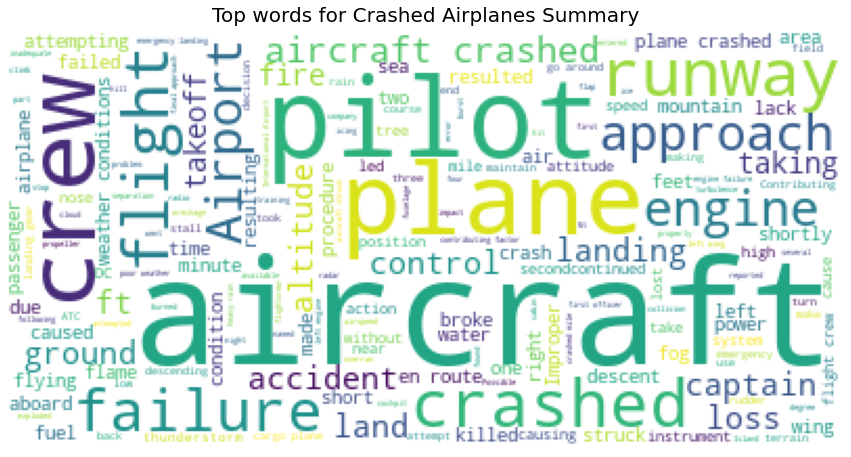

In [41]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wc = WordCloud(
    background_color='white', 
    max_words=200, 
)
wc.generate(' '.join(text for text in airplane['Summary']))
plt.figure(figsize=(15,10))
plt.title('Top words for Crashed Airplanes Summary', 
          fontdict={'size': 20,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [42]:
airplane['Summary_clean'].nunique() 

944

# Kmeans Cluster

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [44]:
documents = list(airplane['Summary_clean'])
vectorizer = TfidfVectorizer(stop_words='english') # Stop words are like "a", "the", or "in" which don't have significant meaning
X = vectorizer.fit_transform(documents)

In [45]:
model = MiniBatchKMeans(n_clusters=5, random_state=100)
model.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=100)

In [46]:
model.cluster_centers_

array([[0.        , 0.        , 0.0004025 , ..., 0.        , 0.        ,
        0.        ],
       [0.00087216, 0.00038323, 0.00315939, ..., 0.        , 0.        ,
        0.00186903],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00069133, ..., 0.00354191, 0.        ,
        0.        ],
       [0.        , 0.        , 0.00144009, ..., 0.        , 0.00435193,
        0.        ]])

In [47]:
model.predict(X)
model.labels_

array([1, 0, 1, 0, 4, 1, 0, 3, 1, 1, 1, 1, 1, 1, 0, 1, 3, 0, 0, 3, 4, 0,
       0, 0, 4, 0, 1, 1, 1, 1, 1, 1, 0, 3, 1, 1, 1, 0, 0, 1, 3, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 3, 3, 0, 1, 1, 1, 1, 1, 4, 3, 3, 4, 1, 1, 1,
       1, 3, 3, 4, 1, 3, 0, 1, 0, 1, 4, 0, 0, 3, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 3, 1, 0, 0, 4, 1, 1, 0, 0, 4, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 3,
       1, 1, 1, 1, 1, 1, 1, 4, 1, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 1, 1, 3,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 3, 0, 1, 4, 1, 0, 0, 2, 1, 1, 4, 4, 3,
       0, 4, 1, 1, 4, 3, 4, 1, 1, 3, 4, 1, 1, 1, 0, 1, 0, 1, 1, 3, 0, 0,
       0, 0, 2, 1, 1, 1, 0, 1, 1, 0, 0, 1, 3, 0, 4, 4, 3, 4, 2, 1, 1, 0,
       4, 1, 0, 1, 1, 3, 4, 3, 1, 1, 1, 0, 4, 3, 0, 0, 0, 4, 1, 1, 3, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 3, 3, 1, 4, 0, 0, 1, 1,
       1, 3, 1, 1, 1, 0, 0, 1, 0, 3, 0, 1, 3, 3, 1, 1, 0, 1, 0, 0, 1, 3,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 4, 0, 1, 3, 0, 3, 0, 0, 3, 1, 1, 0, 4,
       1, 1, 3, 1, 1, 1, 3, 0, 4, 1, 1, 1, 1, 0, 1,

In [48]:
print ('Most Common Terms per Cluster:')

order_centroids = model.cluster_centers_.argsort()[:,::-1] #sort cluster centers by proximity to centroid
terms = vectorizer.get_feature_names()

for i in range(5):
    print("\n")
    print('Cluster %d:' % i)
    for j in order_centroids[i, :10]: #replace 10 with n words per cluster
        print ('%s' % terms[j]),
    print

Most Common Terms per Cluster:


Cluster 0:
plane
aircraft
crash
kill
crew
passeng
caus
fuel
collis
aboard


Cluster 1:
approach
aircraft
runway
land
crash
dure
pilot
crew
plane
attempt


Cluster 2:
hijack
crash
deton
devic
minut
aircraft
plane
explos
aboard
explod


Cluster 3:
mountain
flight
ft
aircraft
crash
navig
terrain
pilot
error
crew


Cluster 4:
engin
failur
aircraft
takeoff
crash
plane
power
loss
left
lost


In [49]:
pca = PCA(n_components=13, random_state=100)
reduced_features = pca.fit_transform(X.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(model.cluster_centers_)

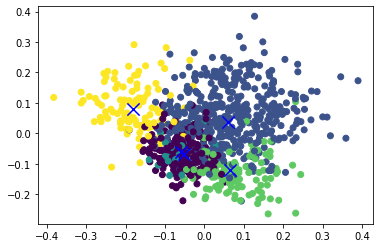

In [50]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=model.predict(X))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

# Modeling

In [51]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split

# NMF

In [52]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/alanoud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [53]:
df=airplane[['Summary_clean','Operator','Location']]

In [54]:
pd.set_option('display.max_colwidth',-1)
df.head(2)

<ipython-input-54-80fd2a1a75bd>:1: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



Summary_clean  \
208  while en rout to los angel the pilot fli a low altitud due to poor weather condit tri to turn back while in a left turn his left wing struck a hill crash and burn advers weather condit the plane flew into a sudden squall which caus the pilot to lose control                                                                               
236  short after take off from kansa citi one of the aircraft wing separ in flight after penetr a thunderstorm and experienc strong turbul and ice the plane crash into a wheat field wingaileron flutter brought about by moistur leak into the wing interior weaken the glue that bond the wooden spar notr dame footbal coach knute rockn  kill   

                              Operator               Location  
208  Maddux Airlines                    Oceanside, California  
236  Trans Continental and Western Air  Bazaar, Kansas

In [55]:
X_train, X_test = train_test_split(df, test_size=0.3, random_state=100)

In [56]:
X_train['Operator'].value_counts()

United Air Lines                            24
Pan American World Airways                  22
American Airlines                           20
Eastern Air Lines                           14
Northwest Orient Airlines                   12
                                            ..
Corporate Airlines (American Connection)    1 
Air Florida                                 1 
Mineral County Airlines                     1 
China General Aviation Corporation          1 
Air Fiji                                    1 
Name: Operator, Length: 403, dtype: int64

In [57]:
stemmer = nltk.stem.SnowballStemmer('english')
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alanoud/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [58]:
def tokenize(text):
    tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2 and len(re.sub('\d+', '', word.strip('Xx/'))) > 3) ] 
    tokens = map(str.lower, tokens)
    stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
    return stems

In [59]:
# Instatiate
vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words=None, max_df=0.75, max_features=1000, lowercase=False, ngram_range=(1,2))
# Fit & Transform
tfidf_vectors = vectorizer.fit_transform(X_train['Summary_clean'].values.astype('U')) ## Even astype(str) would work

In [60]:
tfidf_vectors.shape 

(660, 1000)

In [61]:
tfidf_vectors.A

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.20143554, 0.14332075, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [62]:
len(vectorizer.get_feature_names())

1000

In [63]:
clf = decomposition.NMF(n_components=6, random_state=111) # components is the number of topics

W1 = clf.fit_transform(tfidf_vectors)
H1 = clf.components_

/Users/alanoud/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



In [64]:
# NMF Decomposition
tfidf_vectors.shape

(660, 1000)

In [65]:
W1.shape

(660, 6)

In [66]:
W1

array([[0.03832352, 0.00970656, 0.        , 0.03005955, 0.11004743,
        0.        ],
       [0.02951167, 0.00381576, 0.07967386, 0.03465496, 0.0102786 ,
        0.10408529],
       [0.        , 0.00367442, 0.        , 0.28071666, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.00106026, 0.0458043 , 0.11076502,
        0.        ],
       [0.06297434, 0.        , 0.0308594 , 0.03874552, 0.03805373,
        0.05963113],
       [0.        , 0.23645388, 0.        , 0.05315144, 0.03167682,
        0.        ]])

In [67]:
H1.shape

(6, 1000)

In [68]:
H1

array([[0.04952258, 0.        , 0.        , ..., 0.01273717, 0.00500133,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00520237, 0.        ,
        0.        ],
       [0.01303394, 0.00530832, 0.        , ..., 0.02485654, 0.        ,
        0.        ],
       [0.        , 0.33516037, 0.08896021, ..., 0.        , 0.03870733,
        0.06827193],
       [0.01880211, 0.        , 0.        , ..., 0.        , 0.01619737,
        0.00193014],
       [0.        , 0.        , 0.        , ..., 0.01094382, 0.01776767,
        0.01842648]])

In [69]:
H1[:, 0:1]

array([[0.04952258],
       [0.        ],
       [0.01303394],
       [0.        ],
       [0.01880211],
       [0.        ]])

In [70]:
num_words=10 # TOPIC IS DEFINED AS A COLLECTION OF 15 WORDS

vocab = np.array(vectorizer.get_feature_names())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [71]:
topics

['approach dure descent crew altitud aircraft visual dure approach instrument short runway',
 'engin failur takeoff engin failur power ditch fire left left engin right engin',
 'runway land attempt attempt land plane overran runway overran gear pilot land gear',
 'fire plane aboard passeng crash cabin fuel kill explo minut',
 'mountain condit weather pilot weather condit flight terrain poor error poor weather',
 'control aircraft loss loss control wing turbul sever failur thunderstorm control aircraft']

In [72]:
colnames =["Topic" + str(i) for i in range(clf.n_components)]
docnames = ["Doc" + str(i) for i in range(len(X_train.Summary_clean))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.rename(columns = {"Topic0":"Weather","Topic1":"Fire","Topic2":"Bomb","Topic3":"Failur"
                               ,"Topic4":"Mountain","Topic5":"Crash"} ,inplace = False)

Weather  Fire  Bomb  Failur  Mountain  Crash  dominant_topic
Doc0    0.04     0.01  0.00  0.03    0.11      0.00   4             
Doc1    0.03     0.00  0.08  0.03    0.01      0.10   5             
Doc2    0.00     0.00  0.00  0.28    0.00      0.00   3             
Doc3    0.00     0.15  0.00  0.02    0.00      0.00   1             
Doc4    0.14     0.00  0.04  0.02    0.02      0.01   0             
...      ...      ...   ...   ...     ...       ...  ..             
Doc655  0.00     0.00  0.04  0.08    0.11      0.05   4             
Doc656  0.04     0.01  0.22  0.00    0.02      0.02   2             
Doc657  0.00     0.00  0.00  0.05    0.11      0.00   4             
Doc658  0.06     0.00  0.03  0.04    0.04      0.06   0             
Doc659  0.00     0.24  0.00  0.05    0.03      0.00   1             

[660 rows x 7 columns]

In [73]:
X_train.head()

Summary_clean  \
1121  the plane crash into the north slope of santa ynez peak  mile northwest of santa barbara in poor weather failur of the crew to maintain minimum altitud for the rout be flown for reason unknown                                                                                                                                                                                                                                                                        
3529  the aircraft crash while return to the airport after report sever vibrat while attempt to land the aircraft crash into a  field bounc and slid into mobil home a ground handler forgot to close an air start access door the crew failur to control and monitor the flight path and air speed of the aircraft after detect the vibrat                                                                                                                                   
4773  the aircraft explod and caught fire  minut befor it schedul takeoff five member of the cabin crew were the onli peopl aboard the plane at the time wit said they heard an explos befor flame erupt aboard the aircraft ntsb investig report that the center fuel tank explod follow by the right tank  minut later the caus for the explos was unclear the center fuel tank is locat near air condit pack which generat heat and were run nonstop prior to the explos   
833   crash after loos power in both engin due to fuel starvat the accumul of carburetor ice follow the loss of power in both engin as a result of fuel starvat the reason for fuel starvat could not be determin                                                                                                                                                                                                                                                             
938   while execut a second instrument approach at shannon airport the aircraft struck the ground  feet from the approach end of the intend runway broke apart and burn continu of an instrument approach to an altitud insuffici to clear the terrain the failur of a fluoresc light may have been a contribut caus the plane was name clipper empress of the sky                                                                                                            

                        Operator                                      Location  
1121  Southwest Airways           Refugio Pass, near Santa Barbara, California  
3529  Galaxy Airlines             Reno, Nevada                                  
4773  Thai Airways                Bangkok, Thailand                             
833   American Airlines           Michigan City, Indiana                        
938   Pan American World Airways  Shannon, Ireland

In [74]:
Wtest = clf.transform(vectorizer.transform(X_test.Summary_clean[:10]))

In [75]:
colnames = ["Topic" + str(i) for i in range(clf.n_components)]
docnames = ["Doc" + str(i) for i in range(len(X_test[:10].Summary_clean))]
df_doc_topic = pd.DataFrame(np.round(Wtest, 3), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.rename(columns = {"Topic0":"Weather","Topic1":"Fire","Topic2":"Bomb","Topic3":"Failur"
                               ,"Topic4":"Mountain","Topic5":"Crash"} ,inplace = False)

Weather   Fire   Bomb  Failur  Mountain  Crash  dominant_topic
Doc0  0.134    0.000  0.144  0.024   0.044     0.000  2             
Doc1  0.035    0.024  0.084  0.000   0.000     0.112  5             
Doc2  0.140    0.000  0.000  0.000   0.027     0.000  0             
Doc3  0.006    0.000  0.006  0.060   0.000     0.109  5             
Doc4  0.004    0.050  0.198  0.000   0.000     0.014  2             
Doc5  0.079    0.247  0.045  0.000   0.001     0.020  1             
Doc6  0.029    0.089  0.000  0.000   0.052     0.113  5             
Doc7  0.065    0.000  0.043  0.000   0.056     0.000  0             
Doc8  0.028    0.009  0.180  0.023   0.000     0.084  2             
Doc9  0.000    0.000  0.000  0.046   0.000     0.216  5

# LDA

In [76]:
vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words=None, max_df=0.75, max_features=1000, lowercase=False, ngram_range=(1,2))

tf_vectors = vectorizer.fit_transform(X_train['Summary_clean'].values.astype('U'))

In [77]:
lda = decomposition.LatentDirichletAllocation(n_components=3, max_iter=5, learning_method='online', learning_offset=50, n_jobs=-1, random_state=100)

W1 = lda.fit_transform(tf_vectors)
H1 = lda.components_

In [78]:
W1

array([[0.06319589, 0.06299172, 0.87381239],
       [0.05703123, 0.05673747, 0.88623131],
       [0.05384904, 0.06041798, 0.88573298],
       ...,
       [0.06916485, 0.06923951, 0.86159564],
       [0.06274087, 0.0628884 , 0.87437073],
       [0.07889814, 0.0793824 , 0.84171945]])

In [79]:
W1.shape

(660, 3)

In [80]:
num_words=10

vocab = np.array(vectorizer.get_feature_names())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [81]:
len(topics)

3

In [82]:
topics

['helicopt plane crash aircraft dive sever anoth exerci structur failur',
 'deton cabin explo deton explo explo devic devic bomb compart fire aircraft',
 'aircraft crash plane land engin pilot approach crew runway failur']

In [83]:
colnames = ["Topic" + str(i) for i in range(lda.n_components)]
docnames = ["Doc" + str(i) for i in range(len(X_train.Summary_clean))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.rename(columns = {"Topic0":"Weather","Topic1":"Fire","Topic2":"Crash","Topic3":"Failur"} ,inplace = False)

Weather  Fire  Crash  dominant_topic
Doc0    0.06     0.06  0.87   2             
Doc1    0.06     0.06  0.89   2             
Doc2    0.05     0.06  0.89   2             
Doc3    0.08     0.08  0.83   2             
Doc4    0.06     0.06  0.89   2             
...      ...      ...   ...  ..             
Doc655  0.07     0.07  0.86   2             
Doc656  0.05     0.05  0.89   2             
Doc657  0.07     0.07  0.86   2             
Doc658  0.06     0.06  0.87   2             
Doc659  0.08     0.08  0.84   2             

[660 rows x 4 columns]

In [84]:
X_train.head()

Summary_clean  \
1121  the plane crash into the north slope of santa ynez peak  mile northwest of santa barbara in poor weather failur of the crew to maintain minimum altitud for the rout be flown for reason unknown                                                                                                                                                                                                                                                                        
3529  the aircraft crash while return to the airport after report sever vibrat while attempt to land the aircraft crash into a  field bounc and slid into mobil home a ground handler forgot to close an air start access door the crew failur to control and monitor the flight path and air speed of the aircraft after detect the vibrat                                                                                                                                   
4773  the aircraft explod and caught fire  minut befor it schedul takeoff five member of the cabin crew were the onli peopl aboard the plane at the time wit said they heard an explos befor flame erupt aboard the aircraft ntsb investig report that the center fuel tank explod follow by the right tank  minut later the caus for the explos was unclear the center fuel tank is locat near air condit pack which generat heat and were run nonstop prior to the explos   
833   crash after loos power in both engin due to fuel starvat the accumul of carburetor ice follow the loss of power in both engin as a result of fuel starvat the reason for fuel starvat could not be determin                                                                                                                                                                                                                                                             
938   while execut a second instrument approach at shannon airport the aircraft struck the ground  feet from the approach end of the intend runway broke apart and burn continu of an instrument approach to an altitud insuffici to clear the terrain the failur of a fluoresc light may have been a contribut caus the plane was name clipper empress of the sky                                                                                                            

                        Operator                                      Location  
1121  Southwest Airways           Refugio Pass, near Santa Barbara, California  
3529  Galaxy Airlines             Reno, Nevada                                  
4773  Thai Airways                Bangkok, Thailand                             
833   American Airlines           Michigan City, Indiana                        
938   Pan American World Airways  Shannon, Ireland

In [85]:
Wtest = lda.transform(vectorizer.transform(X_test.Summary_clean[:5]))

In [86]:
Wtest.shape

(5, 3)

In [87]:
colnames = ["Topic" + str(i) for i in range(lda.n_components)]
docnames = ["Doc" + str(i) for i in range(len(X_test.Summary_clean[:5]))]
df_doc_topic = pd.DataFrame(np.round(Wtest, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.rename(columns = {"Topic0":"Weather","Topic1":"Fire","Topic2":"Crash","Topic3":"Failur"} ,inplace = False)

Weather  Fire  Crash  dominant_topic
Doc0  0.06     0.06  0.87   2             
Doc1  0.06     0.06  0.88   2             
Doc2  0.09     0.09  0.83   2             
Doc3  0.08     0.08  0.83   2             
Doc4  0.06     0.06  0.89   2

In [88]:
df_doc_topic.shape

(5, 4)

In [89]:
X_test.shape

(284, 3)

In [90]:
X_test.head()

Summary_clean  \
1369  the plane crash  mile short of the runway while attempt to land crew inattent to flight instrument dure approach pilot sensori illus which gave a  fals impress of the aircraft altitud                                                                                                                              
1759  the aircraft had a unusu long takeoff run and appear to gain altitud with difficulti one and onehalf mile from the runway the aircraft struck tree and crash into a tidal swamp and burst into flame  a jam right elev spring tab caus the crew to lose of control of the aircraft                                   
1179  the plane tree and high ground while on approach the flight deviat from the establish approach procedur                                                                                                                                                                                                              
1318  the aircraft broke up inflight and crash into the sea en rout from rome to cairo metal fatigu due to a design flaw led to the breakup of the aircraft third crash with the same caus the aircraft was nicknam yoke yoke                                                                                              
2437  the militari charter overran the runway dure takeoff hit the il local support structur and burst into flame the lack of acceler undetect by the crew  until after  speed was reach caus by the main land gear wheel remain lock after power was appli for takeoff on the ici runway due to brake or hydraulifailur   

                      Operator                  Location  
1369  American Airlines         Springfield, Mississippi  
1759  Caledonian Airways        Douala, Cameroon          
1179  Flying Tiger Line         Issaquah, Washington      
1318  British Overseas Airways  Off Stromboli, Italy      
2437  Capital Airlines          Anchorage, Alaska

# SVD

In [91]:
example=airplane["Summary_clean"]

In [92]:
vectorizer = CountVectorizer(stop_words = 'english')
doc_word = vectorizer.fit_transform(example)
doc_word.shape

(944, 4220)

In [93]:
pd.DataFrame(doc_word.toarray(), index=example, columns=vectorizer.get_feature_names()).head(2)

aaliyah  \
Summary_clean                                                                                                                                                                                                                                                                                                                                            
while en rout to los angel the pilot fli a low altitud due to poor weather condit tri to turn back while in a left turn his left wing struck a hill crash and burn advers weather condit the plane flew into a sudden squall which caus the pilot to lose control                                                                              0         
short after take off from kansa citi one of the aircraft wing separ in flight after penetr a thunderstorm and experienc strong turbul and ice the plane crash into a wheat field wingaileron flutter brought about by moistur leak into the wing interior weaken the glue that bond the wooden spar notr dame footbal coach knute rockn  kill  0         

                                                                                                                                                                                                                                                                                                                                               ab  \
Summary_clean                                                                                                                                                                                                                                                                                                                                       
while en rout to los angel the pilot fli a low altitud due to poor weather condit tri to turn back while in a left turn his left wing struck a hill crash and burn advers weather condit the plane flew into a sudden squall which caus the pilot to lose control                                                                              0    
short after take off from kansa citi one of the aircraft wing separ in flight after penetr a thunderstorm and experienc strong turbul and ice the plane crash into a wheat field wingaileron flutter brought about by moistur leak into the wing interior weaken the glue that bond the wooden spar notr dame footbal coach knute rockn  kill  0    

                                                                                                                                                                                                                                                                                                                                               abandon  \
Summary_clean                                                                                                                                                                                                                                                                                                                                            
while en rout to los angel the pilot fli a low altitud due to poor weather condit tri to turn back while in a left turn his left wing struck a hill crash and burn advers weather condit the plane flew into a sudden squall which caus the pilot to lose control                                                                              0         
short after take off from kansa citi one of the aircraft wing separ in flight after penetr a thunderstorm and experienc strong turbul and ice the plane crash into a wheat field wingaileron flutter brought about by moistur leak into the wing interior weaken the glue that bond the wooden spar notr dame footbal coach knute rockn  kill  0         

                                                                                                                                                                                                        

In [94]:
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD

lsa = TruncatedSVD(2)
# Fit & Transform
doc_topic = lsa.fit_transform(doc_word)

In [95]:
print (doc_topic)

[[ 2.17599579 -0.39079399]
 [ 1.66552238  0.4575247 ]
 [ 1.62892795 -1.00727486]
 ...
 [ 2.19049059 -0.73886121]
 [ 0.97667845 -0.66095013]
 [ 3.04343333  0.34199179]]


In [96]:
import numpy as np
pd.DataFrame(np.round((doc_topic),4))

0       1
0    2.1760 -0.3908
1    1.6655  0.4575
2    1.6289 -1.0073
3    3.7007 -1.4683
4    1.9853  1.6182
..      ...     ...
939  2.5258 -1.2473
940  2.0485 -1.6775
941  2.1905 -0.7389
942  0.9767 -0.6610
943  3.0434  0.3420

[944 rows x 2 columns]

In [97]:
print (lsa.explained_variance_ratio_)

[0.0361559  0.02936813]


In [98]:
import numpy as np
np.diag(lsa.explained_variance_ratio_)
pd.DataFrame(np.diag(lsa.explained_variance_ratio_))

0         1
0  0.036156  0.000000
1  0.000000  0.029368

In [99]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2"], 
             columns = vectorizer.get_feature_names())
topic_word

aaliyah     ab  abandon  abat   abba  abbrevi  abejorr   abil  \
component_1  0.0      0.001  0.004    0.0   0.002  0.001    0.0      0.001   
component_2 -0.0     -0.001 -0.006   -0.0   0.000 -0.000   -0.0     -0.001   

               abl  abnorm  ...   yuri  zaragoza   zero  zerozero  zimbabw  \
component_1  0.008  0.001   ...  0.000  0.000     0.000  0.000     0.0       
component_2  0.002  0.001   ... -0.002 -0.001     0.003  0.001     0.0       

              zone    zue  zulia   zuma  zurich  
component_1  0.002  0.002  0.0    0.000  0.002   
component_2 -0.001  0.002  0.0    0.001 -0.002   

[2 rows x 4220 columns]

In [100]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [101]:
display_topics(lsa, vectorizer.get_feature_names(), 7)


Topic  0
aircraft, crash, plane, crew, land, pilot, approach

Topic  1
engin, aircraft, caus, loss, left, control, takeoff


In [102]:
Vt = pd.DataFrame(doc_topic.round(10),
             index = example,
             columns = ["component_1","component_2" ])
Vt

component_1  \
Summary_clean                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
while en rout to los angel the pilot fli a low altitud due to poor weather condit tri to turn back while in a left turn his left wing struck a hill crash and burn advers weather condit the plane flew into a sudden squall which caus the pilot to lose control                                                                                                                                                                                                                                                                                                      2.175996      
short after take off from kansa citi one of the aircraft wing separ in flight after penetr a thunderstorm and experienc strong turbul and ice the plane crash into a wheat field wingaileron flutter brought about by moistur leak into the wing interior weaken the glue that bond the wooden spar notr dame footbal coach knute rockn  kill                                                                                                                                                                                                                          1.665522      
the plane crash about  mile from st joseph in heavi fog pilot error in take off in danger weather condit and turn too close the the ground in a fogbound area inaccur weather condit report to the pilot                                                                                                                                                                                                                                                                                                                                                               1.628928      
the plane crash while en rout from albuquerqu to kansa citi after encount fog and poor visibl the plane was divert to kirksvill where wit report the low fli aircraft made contact with the ground and crash whether the plane struck the ground while the pilot was attempt to make an emerg land or becaus the avail fuel suppli had been exhaust or for other reason could not be determin new mexico senat bronson m cut  kill improp clearanc of the airplan from albuquerqu by the compani ground personnel when the plane twoway radio was not function proper  3.700681      
crash  mile south of gilmer the outboard engin separ from the aircraft after a propel blade broke off result in an imbalanc condit which led to loss of control of the aircraft                                                                                                                                                                                                                                                                                                                                                                                        1.985303      
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         ...      
the commut plane crash 